# Viettel AI Challenge: Image Translation

## 1. Load and visualize test images

In [1]:
import warnings
warnings.filterwarnings("ignore")

import cv2
from PIL import Image
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [2]:
# Load images from test folder
test_root_path = "/root/tungn197/genAI/VAC2024/Viettel/task2/test"
test_folder = os.listdir(test_root_path)
file_paths = []
for fname in test_folder:
    file_paths.append(os.path.join(test_root_path, fname))
    
random_elements = random.sample(file_paths, 8)

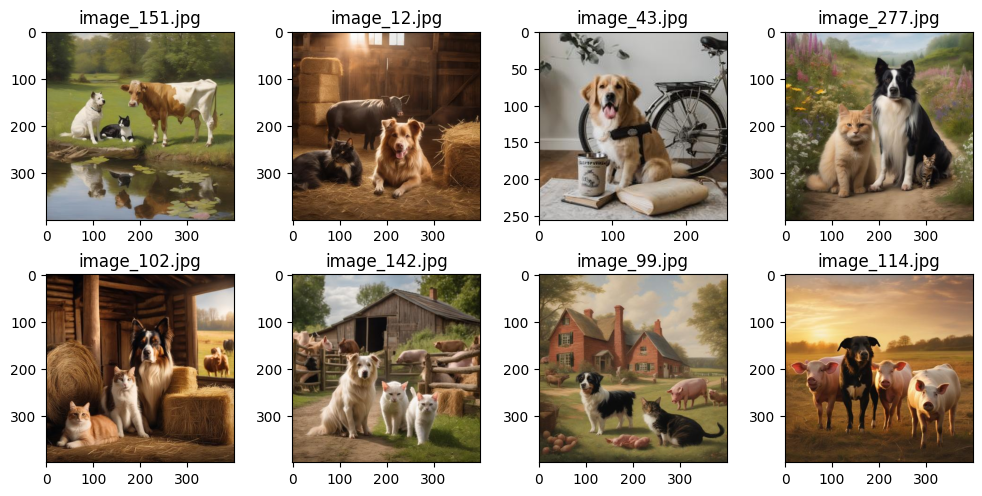

In [3]:
# Create a figure with 2x4 subplots
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

# Load and display each image
for i, path in enumerate(random_elements):
    img = Image.open(path)
    img_array = np.array(img)  # convert to numpy array
    axs[i // 4, i % 4].imshow(img_array)
    axs[i // 4, i % 4].set_title(os.path.basename(path))  # set title to file name
    
# Layout so plots do not overlap
fig.tight_layout()

plt.show()

## 2. Image captioning

In [4]:
from PIL import Image
import base64
import io

def image_to_base64(image_path):
    # Open the image file
    with Image.open(image_path) as img:
        # Create a BytesIO object to hold the image data
        buffered = io.BytesIO()
        # Save the image to the BytesIO object in a specific format (e.g., PNG)
        img.save(buffered, format="PNG")
        # Get the byte data from the BytesIO object
        img_bytes = buffered.getvalue()
        # Encode the byte data to base64
        img_base64 = base64.b64encode(img_bytes).decode('utf-8')
        return img_base64

In [5]:
base64_images = {}
for file_path in file_paths:
    base64_images[file_path] = image_to_base64(file_path)

In [6]:
import ollama
import tqdm
import pandas as pd

ollama_model_id = "x/llama3.2-vision:11b-instruct-q8_0"
images_and_captions = {}
captions = []
image_names = []

# Uncomment the code below to run image captioning

# for key in tqdm.tqdm(base64_images):
#     response = ollama.chat(
#         model=ollama_model_id,
#         messages=[{
#             "role": "user",
#             "content": "Describe this image within 10 words?",
#             "images": [base64_images[key]]
#         }],
#     )
#     cleaned_text = response['message']['content'].strip()
#     images_and_captions[key] = cleaned_text
    
#     image_names.append(os.path.basename(key))
#     captions.append(cleaned_text)
    
#     captioning_data = {
#         "image_name": image_names,
#         "caption": captions
#     }
#     df = pd.DataFrame(captioning_data)
#     df.to_csv('images_and_captions.csv', index=False)

## 3. Visualize images with captions

In [7]:
images_and_captions_df = pd.read_csv("/root/tungn197/genAI/VAC2024/CV/images_and_captions.csv")
images_and_captions_df.head()

,image_name,caption
0,image_112.jpg,A small dog sits next to a bowl of food.
1,image_191.jpg,A dog is running through a field of grass with...
2,image_93.jpg,A dog and cat with a cow in the background.
3,image_103.jpg,A dog is standing on a sidewalk with a butterf...
4,image_159.jpg,A dog is sitting with a camera and tennis ball.


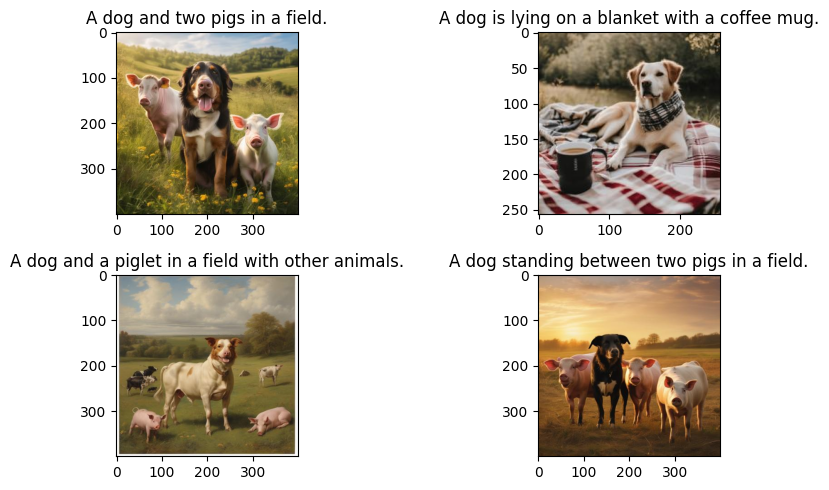

In [8]:

test_root_path = "/root/tungn197/genAI/VAC2024/Viettel/task2/test"

random_indices = random.sample(range(300), 4)
images = []
titles = []
for random_index in random_indices:
    sample = images_and_captions_df.iloc[random_index]
    images.append(os.path.join(test_root_path, sample["image_name"]))
    titles.append(sample["caption"])
    
# Create a figure with 2x4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Load and display each image
for i, path in enumerate(images):
    img = Image.open(path)
    img_array = np.array(img)  # convert to numpy array
    axs[i // 2, i % 2].imshow(img_array)
    axs[i // 2, i % 2].set_title(titles[i])  # set title to file name
    
# Layout so plots do not overlap
fig.tight_layout()

plt.show()

## 4. Image2Image with Stable Diffusion

In [29]:
import requests
import torch
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline, DPMSolverMultistepScheduler,\
    DPMSolverSinglestepScheduler, FlowMatchEulerDiscreteScheduler

In [30]:
schedulers = {"Euler": (FlowMatchEulerDiscreteScheduler,
                        {}),
              "DPM++ 2M": (DPMSolverMultistepScheduler,
                           {}),
              "DPM++ 2M Karras": (DPMSolverMultistepScheduler,
                                  {"use_karras_sigmas": True}),
              "DPM++ 2M SDE": (DPMSolverMultistepScheduler,
                               {"algorithm_type": "sde-dpmsolver++"},
                               ),
              "DPM++ 2M SDE Karras": (DPMSolverMultistepScheduler,
                                      {"use_karras_sigmas": True,
                                       "algorithm_type": "sde-dpmsolver++"},
                                      ),
              "DPM++ SDE": (DPMSolverSinglestepScheduler,
                            {}),
              "DPM++ SDE Karras": (DPMSolverSinglestepScheduler,
                                   {"use_karras_sigmas": True}),
              }


def apply_scheduler(name, pipeline):
    # Check if the scheduler name exists in the schedulers dictionary
    if name in schedulers:
        scheduler_class, config = schedulers[name]
        # Update the pipeline's scheduler with the selected scheduler class and
        # configuration
        pipeline.scheduler = scheduler_class.from_config(
            pipeline.scheduler.config, **config)
    return pipeline

In [77]:
device = "cuda:1"
model_id = "runwayml/stable-diffusion-v1-5"
# model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


In [80]:
pipe.safety_checker = None
pipe = apply_scheduler("DPM++ 2M Karras", pipe)

/root/tungn197/genAI/VAC2024/Viettel/task2/test/image_266.jpg	A dog and a cow in a grassy field.
8k, masterpiece, A cat and a cow in a grassy field.


100%|██████████| 30/30 [00:01<00:00, 16.48it/s]


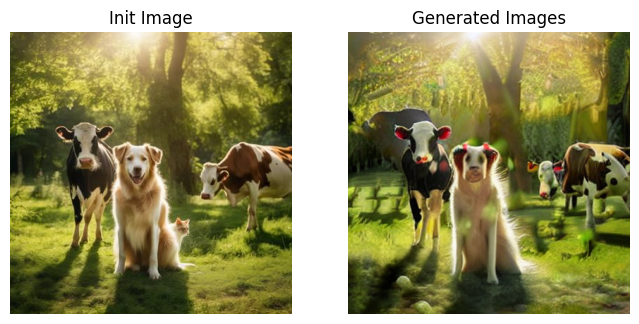

In [90]:

images_and_captions_df = pd.read_csv("/root/tungn197/genAI/VAC2024/CV/images_and_captions.csv")
test_root_path = "/root/tungn197/genAI/VAC2024/Viettel/task2/test"
random_number = random.randint(0, len(images_and_captions_df) - 1)
sample = images_and_captions_df.iloc[random_number]
image_path = os.path.join(test_root_path, sample["image_name"])
caption = sample["caption"]
print(f"{image_path}\t{caption}")

# Generate image
init_image = Image.open(image_path)
prompt = caption.replace("dog", "cat")
# prompt = "replace dogs by cats"
prompt = "8k, masterpiece, " + prompt
negative_prompt = "ugly, painting"

print(prompt)
generated_images = pipe(prompt=prompt,
                        negative_prompt=negative_prompt,
                        image=init_image,
                        strength=0.5,
                        num_inference_steps=60,
                        guidance_scale=2).images
# generated_images[0].save("test_output.png")

# Display the result
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(init_image)
ax[0].axis('off')
ax[0].set_title("Init Image")

ax[1].imshow(generated_images[0])
ax[1].axis('off')
ax[1].set_title("Generated Images")

# Display the images
plt.show()